# Chapter 6: Markov Chain Monte Carlo

## Introduction to Markov chains
Markov chain Monte Carlo (Markov Chain simulation or MCMC for short) is a Bayesian way of finding values of $\theta$ from an approximate distribution, where $\theta$ are the unknown parameters that make up the distribution. The Markov chain algorithm corrects this approximate distribution in each iteration, eventually converging to a final distribution that aligns with the posterior distribution $p(\theta|y)$. This is particularly useful when the posterior is difficult or impossible to sample making MCMC a powerful tool.

This is done by constructing a stationary Markov chain, a sequence of random variables, $\theta_1, ... , \theta_t$, where the $\theta_t$ have the same distribution as the posterior. Now instead of taking independent variables, the Markov chain introduces variables $\theta_t$ obeying the Markov property

$$
	p(\theta_{t+1} | \theta_{t},...,\theta_1) = p(\theta_{t+1}|\theta_{t}),
$$
such that the variable $\theta_{t+1}$ is only dependent on the most recent variable $\theta_{t}$ and therefore, the distribution of $\theta_{t+1}$ does not depend on how the chain got to $\theta_{t}$, but only what this state is. In other words, one could say that "_What comes next is determined entirely by the present situation._"
Eventually, this converging of the distribution is where the power of Markov chain simulations lies, allowing for the determination of the original distribution solely from its data. 

Markov chain simulations are frequently used when it is inefficient to find $\theta$ directly from the posterior $p(\theta|y).$ As mentioned before, we sample a new $\theta$ iteratively, with the expectation that the distribution converges more and more to $p(\theta|y).$ Generally, MCMC is exceptionally effective for high-dimensional distributions, as direct-sampling Monte Carlo methods cannot complete such analysis in a reasonable time. 

MCMC algorithms, such as Metropolis-Hasting and affine parameters, propose and accept new steps of the MCMC chain in the parameter space, allowing the chain to explore the parameter space.

## Explanation of Metropolis-Hasting
The simplest method of simulating a Markov chain is the Metropolis-Hastings algorithm, which itself relies on the more basic Metropolis algorithm. This we will inquire about first.

The Metropolis algorithm expands on a random walk with a rule that accepts or rejects the sampled data to converge the sampled data to the specified target distribution. This accepting and rejecting is based on a given rule. The algorithm works as follows:
1. Draw a starting point $\theta_0$ with $p(\theta_0|y) > 0$ from a certain starting distribution $p_0(\theta)$. For example, $p_0(\theta) \sim \mathcal{N}(\theta_{t-1}, \sigma^2)$ if $\theta \in \mathbb{R}$ \citep{nagler2021statistics}.

2. For $t = 1, 2, \ldots$:

   a. Sample a proposal $\theta_\ast$ from a proposal distribution $J_t(\theta_\ast|\theta_{t-1})$ at time $t$. We require $J_t(\theta_a|\theta_b) = J_t(\theta_b|\theta_a)$ for all $\theta_a$, $\theta_b$, and $t$ for now.

   b. Calculate the ratio of the densities of $\theta_a$ and $\theta_b$:

      $$
      r = \frac{p(\theta_a|y)}{p(\theta_b|y)} = \frac{p(\theta_{\ast}|y)}{p(\theta_{t-1}|y)}.
      $$
      
   c. Set 

      $$
      \theta_t = \begin{cases}
         \theta_\ast &\ \text{with probability } \min(r, 1), \\
         \theta_{t-1} &\ \text{otherwise}.
      \end{cases}
      $$

To put this into words; a value of $\theta_*$ is sampled from a previous distribution, and if the ratio of densities is lower than a random uniform variable, the proposed state is rejected and $\theta_t$ = $\theta_{t-1}$.

Now we return to the Metropolis-Hastings (MH) algorithm. In contrast to the Metropolis algorithm, the MH algorithm does not require $J_t(\theta_*|\theta_{t-1})$ to be symmetric. Due to this new, asymmetric proposal distribution, we must alter the ratio of densities of $\theta_a$ and $\theta_b$, which is as follows:

$$ 
r = \frac{p(\theta_{\ast}|y)J_t(\theta_{t-1}|\theta_{\ast})}{p(\theta_{t-1}| y)J_t(\theta_{\ast}|\theta_{t-1})}
$$

For the proposal distribution, the following characteristics are favorable:
- It is easy to sample from $ J(\theta_{\ast}|\theta) $ for any $\theta$.
- The ratio of $r$ (as given by the above equation) is easy to calculate.
- The random walk does not go too slowly, i.e., the sampled values are not too close together.
- Rejected jumps do not happen often, as they hurt the performance of the algorithm.
### Burn-in Time and Autocorrelation
In the Metropolis-Hastings algorithm, the chain takes some steps to reach a stable value, called the burn-in time. We discard these points before we make the probability distribution. In a one-parameter fit, this can easily be done by eye. However, in fits with many parameters, you would prefer an automated process to take care of this. This can be done via autocorrelation. If we have the chain $\{X_1, X_2,...,X_n\}$ we can calculate the autocorrelation coefficient with
$$
\rho(k)=\frac{1}{(n-k)\sigma^2}\sum_{t=1}^{n-k}(X_t-\mu)(X_{t+k}-\mu)
$$
where $k$ is the lag or time gap between the samples and $\mu$ the mean. We can choose a threshold value, say 0.1, and calculate above which value of $k$ the autocorrelation coefficient is below the threshold. We can then take $\{X_k,...,X_n\}$ to be samples from our posterior distribution. In the example below we will use autocorrelation to determine the burn-in time.




### 1D Example
We have collected data and want to infer the mean and its error. The data points are $y_i=$[1,2,3] with error $\sigma_{y_i}=$[1,1,1]. We can do this analytically and find $\mu=2$ and $\sigma_\mu=1/\sqrt{3}\approx0.577$. We want to derive these values using the Metropolis-Hasting algorithm. First, we need to construct the posterior. We will assume a flat prior making the posterior the likelihood. Next, we pick a starting point for the Markov chain. Using this as the center of a normal distribution, a new point is drawn from the distribution. We find the ratio of the new points posterior to the last point. If the ratio is larger than a random value between 0 and 1, we accept the new point to the chain. Otherwise, the last point value is added to the chain. These steps are repeated until we can reconstruct the desired distribution for $\mu$. We take 10 as the starting point and use a starting distribution with a scale parameter of 3. This allows the chain to converge to the correct value quickly. 

As mentioned before, the chain takes some steps to get to a stable value. We disregard these points before we make the probability distribution. 



The burn-in time is at step 14.


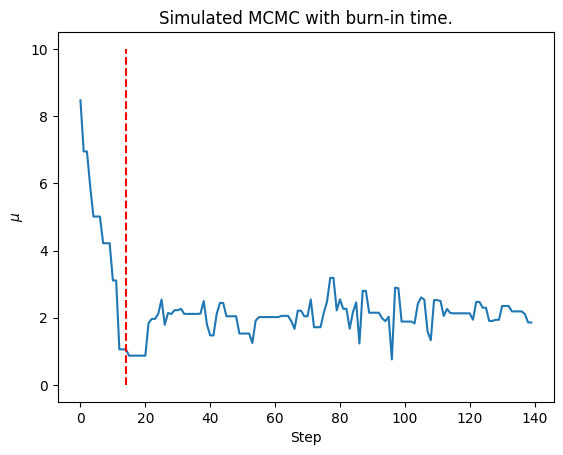

Simulated mean: 2.012, True mean: 2
Simulated error: 0.591, True error: 1/√3


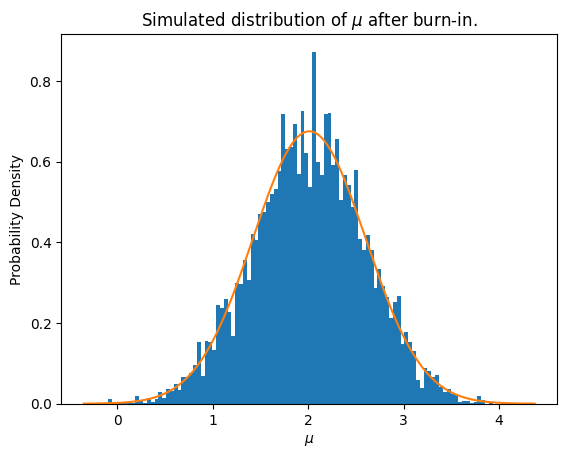

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

steps = 10000
X = 10
Xs = []
y = np.array([1, 2, 3])
y_sigma = np.array([1, 1, 1])


def prob_dist(mu):
    return np.exp(-1 * np.sum(((y - mu) ** 2 / (2 * y_sigma ** 2))))


def autocorrelation(chain, lag):
    return np.sum((chain[:len(chain) - lag] - np.mean(chain)) * (chain[lag:] - np.mean(chain))) / (
                len(chain) - lag) / np.var(chain)


for _ in range(steps):
    Y = np.random.normal(X, 1)
    q = prob_dist(Y) / prob_dist(X)
    if q >= np.random.rand():
        X = Y
    Xs.append(X)


auto = np.inf
index = 1
while auto >= 0.01:
    auto = autocorrelation(Xs, index)
    index += 1
    if index >= len(Xs):
        print('autocorrelation failed')
        break
        
print(f'The burn-in time is at step {index}.')
plt.figure()
plt.plot(Xs[:10 * index])
plt.vlines(index, 0, 10, colors='red', linestyles='dashed')
plt.xlabel('Step')
plt.ylabel(r'$\mu$')
plt.title('Simulated MCMC with burn-in time.')
plt.show()


plt.figure()
plt.hist(Xs[index:], bins=steps // 100, density=True)
mu = np.mean(Xs[index:])
mu_sigma = np.std(Xs[index:])
print(f'Simulated mean: {mu:.3f}, True mean: 2')
print(f'Simulated error: {mu_sigma:.3f}, True error: 1/√3')
x = np.linspace(mu - 4 * mu_sigma, mu + 4 * mu_sigma, 1000)
plt.plot(x, norm.pdf(x, mu, mu_sigma))
plt.xlabel(r'$\mu$')
plt.ylabel('Probability Density')
plt.title(r'Simulated distribution of $\mu$ after burn-in.')
plt.show()